# Assignment 4: Niveditha Achanta

In this assignment, you'll combine the assignment 3 data set with nutrition data from the [USDA Food Composition Databases](https://ndb.nal.usda.gov/ndb/search/list). The CSV file `fresh.csv` contains the fresh fruits and vegetables data you extracted in assignment 3.

The USDA Food Composition Databases have a [documented](https://ndb.nal.usda.gov/ndb/doc/index) web API that returns data in JSON format . You need a key in order to use the API. Only 1000 requests are allowed per hour, so it would be a good idea to use [caching][requests_cache].

[Sign up for an API key here](https://api.data.gov/signup/). The key will work with any Data.gov API. You may need the key again later in the quarter, so make sure you save it.

These modules may be useful:

* [requests](http://docs.python-requests.org/en/master/user/quickstart/)
* [requests_cache][]
* [urlparse](https://docs.python.org/2/library/urlparse.html)
* [pandas](http://pandas.pydata.org/pandas-docs/stable/)

[requests_cache]: https://pypi.python.org/pypi/requests-cache

In [276]:
import requests
import requests_cache
import urlparse
import pandas as pd
import json
import os
import glob
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [277]:
requests_cache.install_cache('demo_cache')

__API key:__ DGg2xJm5VVML7nE45ooZjKhnht2tFk197ayqvxaK

__Exercise 1.1.__ Read the [search request documentation](https://ndb.nal.usda.gov/ndb/doc/apilist/API-SEARCH.md), then write a function called `ndb_search()` that makes a search request. The function should accept the search term as an argument. The function should return the search result items as a list (for 0 items, return an empty list).

Note that the search url is: `https://api.nal.usda.gov/ndb/search`

As an example, a search for `"quail eggs"` should return this list:

```python
[{u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'CHAOKOH, QUAIL EGG IN BRINE, UPC: 044738074186',
  u'ndbno': u'45094707',
  u'offset': 0},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'L&W, QUAIL EGGS, UPC: 024072000256',
  u'ndbno': u'45094890',
  u'offset': 1},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'BUDDHA, QUAIL EGGS IN BRINE, UPC: 761934535098',
  u'ndbno': u'45099560',
  u'offset': 2},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'GRAN SABANA, QUAIL EGGS, UPC: 819140010103',
  u'ndbno': u'45169279',
  u'offset': 3},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u"D'ARTAGNAN, QUAIL EGGS, UPC: 736622102630",
  u'ndbno': u'45178254',
  u'offset': 4},
 {u'ds': u'SR',
  u'group': u'Dairy and Egg Products',
  u'name': u'Egg, quail, whole, fresh, raw',
  u'ndbno': u'01140',
  u'offset': 5}]
```

As usual, make sure you document and test your function.

In [278]:
key = "DGg2xJm5VVML7nE45ooZjKhnht2tFk197ayqvxaK" #your API key goes here
  
def ndb_search(key, term, sort='r', data_source="Standard Reference", group=""):
    """
    accept the search term as an argument and
    return the search result items as a list (for 0 items, return an empty list)
    """
    #set parameters max,offset, and sort
    url = 'https://api.nal.usda.gov/ndb/search'
    response = requests.get(url, params = {
        "q": term,
        "format": "json",
        "sort": sort,
        "ds": data_source,
        "fg": group, 
        "api_key": key
        
    })

    response.raise_for_status() # check for errors
    try:
        list_out = response.json()['list']['item']
    except KeyError:
        list_out=[]
    return list_out
        
ndb_search(key, "","","","")

[{u'ds': u'SR',
  u'group': u'Dairy and Egg Products',
  u'name': u'Butter, salted',
  u'ndbno': u'01001',
  u'offset': 0},
 {u'ds': u'SR',
  u'group': u'Dairy and Egg Products',
  u'name': u'Butter, whipped, with salt',
  u'ndbno': u'01002',
  u'offset': 1},
 {u'ds': u'SR',
  u'group': u'Dairy and Egg Products',
  u'name': u'Butter oil, anhydrous',
  u'ndbno': u'01003',
  u'offset': 2},
 {u'ds': u'SR',
  u'group': u'Dairy and Egg Products',
  u'name': u'Cheese, blue',
  u'ndbno': u'01004',
  u'offset': 3},
 {u'ds': u'SR',
  u'group': u'Dairy and Egg Products',
  u'name': u'Cheese, brick',
  u'ndbno': u'01005',
  u'offset': 4},
 {u'ds': u'SR',
  u'group': u'Dairy and Egg Products',
  u'name': u'Cheese, brie',
  u'ndbno': u'01006',
  u'offset': 5},
 {u'ds': u'SR',
  u'group': u'Dairy and Egg Products',
  u'name': u'Cheese, camembert',
  u'ndbno': u'01007',
  u'offset': 6},
 {u'ds': u'SR',
  u'group': u'Dairy and Egg Products',
  u'name': u'Cheese, caraway',
  u'ndbno': u'01008',
  u'off

__Comments:__ Please note that the above code makes provisions for having 6 out of 8 parameters described in the search documentation being dynamic. The only "set" parameters are the format, which we want in JSON, and the api key, which is unique to the user. All other paramters can be changed in the function. The last two, data source and group, are going to become relevant in the next few exercises. From now on, we're going to set data source to Standard Reference, because that's the one we want information for in future problems. 

__Exercise 1.2.__ Use your search function to get NDB numbers for the foods in the `fresh.csv` file. It's okay if you don't get an NDB number for every food, but try to come up with a strategy that gets most of them. Discuss your strategy in a short paragraph.

Hints:

* The foods are all raw and unbranded.
* You can test search terms with the [online search page](https://ndb.nal.usda.gov/ndb/search/list).
* You can convert the output of `ndb_search()` to a data frame with `pd.DataFrame()`.
* The string methods for [Python](https://docs.python.org/2/library/stdtypes.html#string-methods) and [Pandas](http://pandas.pydata.org/pandas-docs/stable/text.html#method-summary) are useful here. It's okay if you use _simple_ regular expressions in the Pandas methods, although this exercise can be solved without them.
* You can merge data frames that have a column in common with `pd.merge()`.

__1.2 Strategy Part 1:__ First, I will import `fresh.csv` as "fresh." In the first cell, I will rename a column for ease so I can use it in the function I write below. Then, in the next cell, I'm creating a pandas dataframe that contains only fruit and vegetable information from data.gov that contains the word "raw" and falls into "Standard Reference", because this meets the criteria/hints specified. In the third cell, I write a function called `match_names()` that iterates through the names in the dataframe created from `fresh.csv`, and matches them with the data.gov dataframe. I use a simple regular expression, because some of the food names contain underscores and other extraneous information that can most effectively be matched through regex. Some issues I encounter through this strategy are discussed below. 

In [279]:
#Cell 1
fresh = pd.read_csv('fresh.csv') #Read in CSV 
fresh.rename(columns={'food': 'name', 'type': 'foodtype'}, inplace=True) #Rename columns
#fresh

In [280]:
#Cell 2
fruitdata = pd.io.json.json_normalize(ndb_search(key, "", "r",  "Standard Reference", "Fruits and Fruit Juices"))
vegdata = pd.io.json.json_normalize(ndb_search(key, "", "r", "Standard Reference", "Vegetables and Vegetable Products"))
df = fruitdata.append(vegdata) #append fruit and veg dataframes
df = df.loc[df.name.str.endswith(", raw"), :] #gets only the foods for which the name ends with "raw"

In [281]:
#Cell 3
def match_names(foodname): 
    fresh_names = list(fresh['name'])
    foodname = " ".join(foodname.split("_"))+" raw"
    #print fresh_names
    fn_names = ndb_search(key, foodname)
    try:
        return fn_names[0]['ndbno'] 
    except IndexError: #There is a problem with kiwis, as explained below
        return ""

__1.2 Strategy Part 2:__ Now we want to use this function to create a dataframe that will give us the ndb_nums for every item in fresh. We do that below by making it iterate through every name in `fresh.csv`, and our final dataframe is returned below.

In [282]:
the_ndbs = [match_names(f) for f in fresh.name] #Iterates through the column "name" in fresh
df_nums = pd.DataFrame(the_ndbs) #Create a dataframe of ndb numbers
frames = (fresh, df_nums)
final_df = pd.concat(frames, axis=1) #Concatenate the df of ndb numbers to the original fresh dataframe
final_df.rename(columns={0L: 'ndb_nums'}, inplace=True)
final_df

,form,price_per_lb,yield,lb_per_cup,price_per_cup,name,foodtype,ndb_nums
0,Fresh1,0.333412,0.520000,0.330693,0.212033,watermelon,fruit,09326
1,Fresh1,0.535874,0.510000,0.374786,0.393800,cantaloupe,fruit,09181
2,Fresh1,1.377962,0.740000,0.407855,0.759471,tangerines,fruit,09221
3,Fresh1,2.358808,0.940000,0.319670,0.802171,strawberries,fruit,09316
4,Fresh1,1.827416,0.940000,0.363763,0.707176,plums,fruit,09279
5,Fresh1,1.035173,0.730000,0.407855,0.578357,oranges,fruit,09201
6,Fresh1,6.975811,0.960000,0.319670,2.322874,raspberries,fruit,09302
7,Fresh1,2.173590,0.560000,0.341717,1.326342,pomegranate,fruit,09286
8,Fresh1,0.627662,0.510000,0.363763,0.447686,pineapple,fruit,09266
9,Fresh1,3.040072,0.930000,0.363763,1.189102,apricots,fruit,09021


__1.2 Strategy Issues:__ It needs to be noted that there are a few issues that primarily arise with matching and duplicates. First of all, I don't have an ndb number for kiwis. This is probably because it is named "kiwifruit" in `fresh.csv`. This can be hardcoded at will, but I'm choosing not to do so, because it won't always be feasible to visually scan the data for issues like it is right now. Similarly, cabbage and cucumbers are both duplicates and both of those rows have the same ndb number even though they refer to different things. There doesn't seem to be a raw red cabbage or a raw green cabbage in the data.gov database, and this function returns the first ndb number for the cabbage list, which in our case is swamp cabbage. It's probably not the one we want, although there only is one type of overall "Cabbage, raw" in data.gov. There is no differentiation across colors. For cucumbers, the function returns the ndb number for "Cucumber, peeled, raw" for both cucumbers. These three issues can be solved by hard-coding, but I think it may be better practices to simply address them here. 

The dataframe below, `fruitvegdata`, has all the information we need, i.e., it contains all the information for fruits and vegetables in fresh.csv. Our next task is to actually find the ndb number of the most relevant result.

__Exercise 1.3.__ Read the [food reports V2 documentation](https://ndb.nal.usda.gov/ndb/doc/apilist/API-FOOD-REPORTV2.md), then write a function called `ndb_report()` that requests a _basic_ food report. The function should accept the NDB number as an argument and return the list of nutrients for the food.

Note that the report url is: `https://api.nal.usda.gov/ndb/V2/reports`

For example, for `"09279"` (raw plums) the first element of the returned list should be:

```python
{u'group': u'Proximates',
 u'measures': [{u'eqv': 165.0,
   u'eunit': u'g',
   u'label': u'cup, sliced',
   u'qty': 1.0,
   u'value': u'143.93'},
  {u'eqv': 66.0,
   u'eunit': u'g',
   u'label': u'fruit (2-1/8" dia)',
   u'qty': 1.0,
   u'value': u'57.57'},
  {u'eqv': 151.0,
   u'eunit': u'g',
   u'label': u'NLEA serving',
   u'qty': 1.0,
   u'value': u'131.72'}],
 u'name': u'Water',
 u'nutrient_id': u'255',
 u'unit': u'g',
 u'value': u'87.23'}
```

Be sure to document and test your function.

In [283]:
def ndb_report(ndb_num):
    """
    accept the ndb number as an argument and
    return the search result items as a list (for 0 items, return an empty list)
    """
    #set parameters max,offset, and sort
    url = 'https://api.nal.usda.gov/ndb/V2/reports'
    key = "DGg2xJm5VVML7nE45ooZjKhnht2tFk197ayqvxaK"
    response = requests.get(url, params = {
        "ndbno": ndb_num,
        "format": "json",
        "type": "b",
        "api_key": key
        
    })

    response.raise_for_status() # check for errors
    try:
        list_out = response.json()['foods'][0]['food']['nutrients'] #since we want the nutrient information 
    except KeyError:
        list_out=[]
    return list_out
#ndb_report("09279") #for plums

[{u'group': u'Proximates',
  u'measures': [{u'eqv': 165.0,
    u'eunit': u'g',
    u'label': u'cup, sliced',
    u'qty': 1.0,
    u'value': u'143.93'},
   {u'eqv': 66.0,
    u'eunit': u'g',
    u'label': u'fruit (2-1/8" dia)',
    u'qty': 1.0,
    u'value': u'57.57'},
   {u'eqv': 151.0,
    u'eunit': u'g',
    u'label': u'NLEA serving',
    u'qty': 1.0,
    u'value': u'131.72'}],
  u'name': u'Water',
  u'nutrient_id': u'255',
  u'unit': u'g',
  u'value': u'87.23'},
 {u'group': u'Proximates',
  u'measures': [{u'eqv': 165.0,
    u'eunit': u'g',
    u'label': u'cup, sliced',
    u'qty': 1.0,
    u'value': u'76'},
   {u'eqv': 66.0,
    u'eunit': u'g',
    u'label': u'fruit (2-1/8" dia)',
    u'qty': 1.0,
    u'value': u'30'},
   {u'eqv': 151.0,
    u'eunit': u'g',
    u'label': u'NLEA serving',
    u'qty': 1.0,
    u'value': u'69'}],
  u'name': u'Energy',
  u'nutrient_id': u'208',
  u'unit': u'kcal',
  u'value': u'46'},
 {u'group': u'Proximates',
  u'measures': [{u'eqv': 165.0,
    u'eunit

__Exercise 1.4.__ Which foods provide the best combination of price, yield, and nutrition? You can use kilocalories as a measure of "nutrition" here, but more a detailed analysis is better. Use plots to support your analysis.

__1.4 Strategy:__ When we call the cell below for just one fruit or vegetable (e.g. raw plums, arbitrarily), and specify that we want ["name"], we can get the list of all nutrient names. Similarly, ["value"] returns the actual numeric value of all these nutrients, and this information can be known from looking at the structure of the dictionary that 1.3 returns. After looking at all the names, I chose a few that I thought would be relevant in measuring "nutrition", specifically energy, protein, fiber, and iron. Keep in mind that this is subjective, and is addressed later in __"1.4 Strategy Comments"__ at the end of the assignment. 

All the values I chose are graphed below, as well as price and yield information. For some information, I have graphed all the relevant fruits and vegetables, and for some of the more specific nutrient information, I simply picked the top 5 nutrient-rich foods, across both fruits and vegetables. Depending on the specific parameters of the task, we can narrow these down and split into fruits and vegetables, and split it further into different fruit/veggie "groups", but due to time constraints, I look at them all on an aggregate basis.

There are also brief notes after some of the graphs.

In [274]:
#[ndb_report(u'09279')[x]["name"] for x in range(len(ndb_report(u'09279')))] #List of all nutrient names

In [284]:
#Sorry Nick

#Call the value of the specified nutrient in the individual report for each food

energy = [[one_report["value"] for one_report in ndb_report(all_reports) if 'Energy' in one_report["name"]] for all_reports in final_df.ndb_nums]
protein = [[one_report["value"] for one_report in ndb_report(all_reports) if 'Protein' in one_report["name"]] for all_reports in final_df.ndb_nums]
fiber = [[one_report["value"] for one_report in ndb_report(all_reports) if 'Fiber' in one_report["name"]] for all_reports in final_df.ndb_nums]
iron = [[one_report["value"] for one_report in ndb_report(all_reports) if 'Iron' in one_report["name"]] for all_reports in final_df.ndb_nums]
nut_df = pd.DataFrame(
    {'energy': energy,
     'protein': protein,
     'fiber': fiber,
     'iron': iron
    })
nut_df2 = pd.DataFrame([[float(entry[0]) if len(entry)==1 else np.nan for entry in row] for index,row in nut_df.iterrows()])
dfs = (final_df, nut_df2)
final_dfs = pd.concat(dfs, axis=1)
final_dfs.rename(columns={0L: 'energy', 1L: 'protein', 2L: 'fiber', 3L: 'iron'}, inplace=True)
final_dfs #Visualize all the information I want in a dataframe.

,form,price_per_lb,yield,lb_per_cup,price_per_cup,name,foodtype,ndb_nums,energy,protein,fiber,iron
0,Fresh1,0.333412,0.520000,0.330693,0.212033,watermelon,fruit,09326,30.0,0.4,0.24,0.61
1,Fresh1,0.535874,0.510000,0.374786,0.393800,cantaloupe,fruit,09181,34.0,0.9,0.21,0.84
2,Fresh1,1.377962,0.740000,0.407855,0.759471,tangerines,fruit,09221,43.0,0.2,0.20,0.50
3,Fresh1,2.358808,0.940000,0.319670,0.802171,strawberries,fruit,09316,32.0,2.0,0.41,0.67
4,Fresh1,1.827416,0.940000,0.363763,0.707176,plums,fruit,09279,46.0,1.4,0.17,0.70
5,Fresh1,1.035173,0.730000,0.407855,0.578357,oranges,fruit,09201,49.0,2.5,0.09,1.04
6,Fresh1,6.975811,0.960000,0.319670,2.322874,raspberries,fruit,09302,52.0,6.5,0.69,1.20
7,Fresh1,2.173590,0.560000,0.341717,1.326342,pomegranate,fruit,09286,83.0,4.0,0.30,1.67
8,Fresh1,0.627662,0.510000,0.363763,0.447686,pineapple,fruit,09266,50.0,1.4,0.29,0.54
9,Fresh1,3.040072,0.930000,0.363763,1.189102,apricots,fruit,09021,48.0,2.0,0.39,1.40


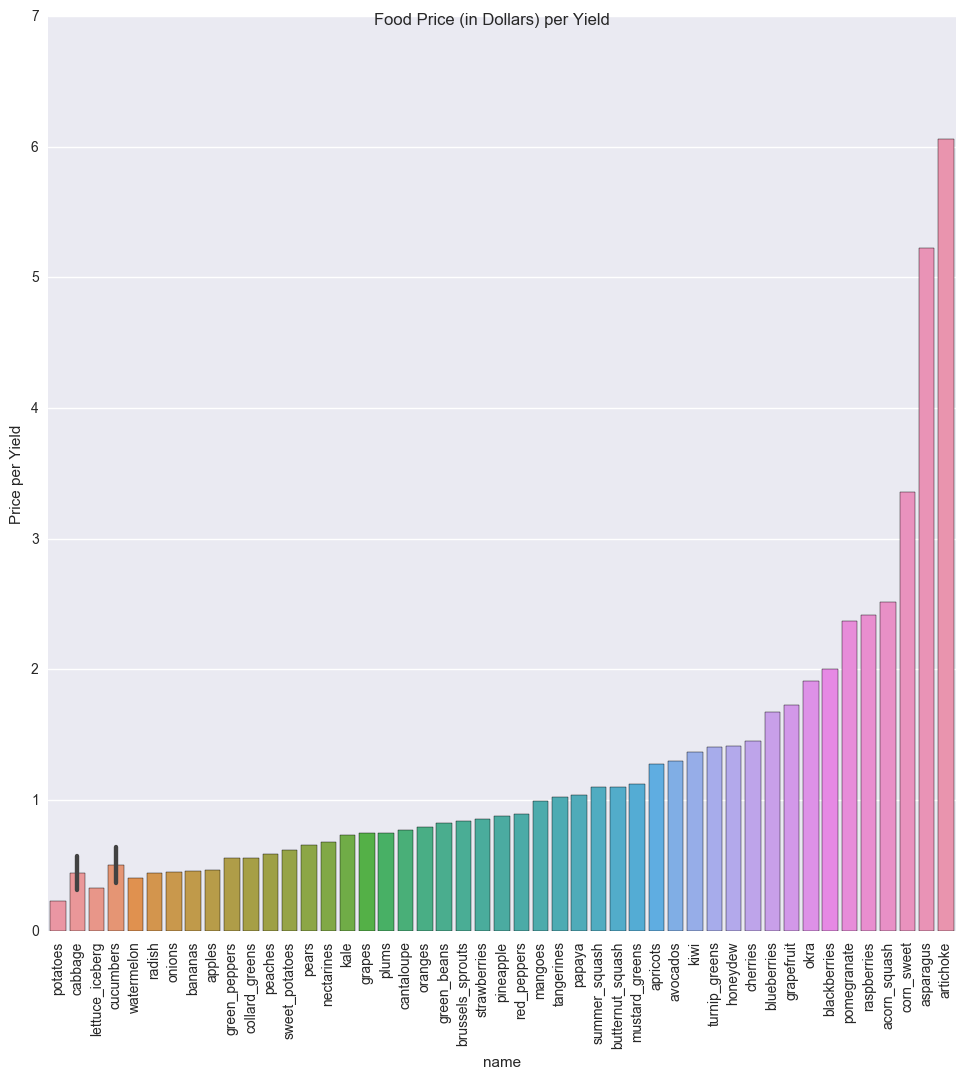

In [287]:
#Best value  
final_dfs['Price per Yield'] = final_dfs['price_per_cup']/final_dfs['yield']
final_dfs = final_dfs.sort_values(by = "Price per Yield", axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last') 
valplot=sns.factorplot("name", "Price per Yield", data = final_dfs, kind = "bar", size=10) #Barplot
valplot.set_xticklabels(rotation=90) #Rotate axis labels for readability
valplot.fig.suptitle('Food Price (in Dollars) per Yield')
plt.show(valplot)

__Notes:__ First of all, we see that potatoes, cabbage, iceberg lettuce, cucumbers, and watermelon have the best combination of price and yield. We want to look at foods' energy to get a measure of kilocalories. We also want to look at foods' protein, fiber, and iron. 

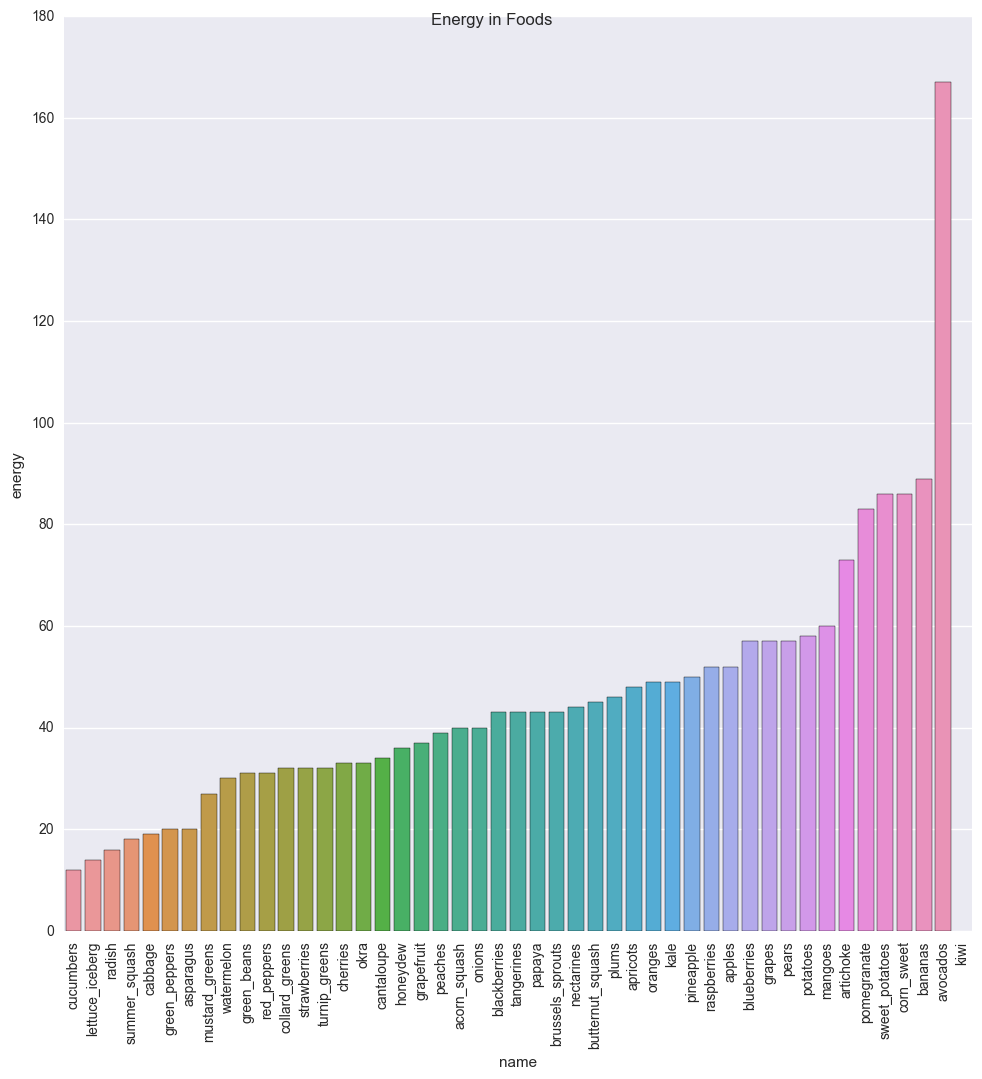

In [288]:
final_dfs = final_dfs.sort_values(by = "energy", axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last') 
calplot=sns.factorplot("name", "energy", data = final_dfs, kind = "bar", size=10) #Barplot
calplot.set_xticklabels(rotation=90) #Rotate axis labels for readability
calplot.fig.suptitle('Energy in Foods')
plt.show(calplot)

__Notes:__ We can see the amount of kilocalories for each food in the plot above. Avocados definitely stand out as having the most kilocalories, and that might be attributed to the amount of fat they have. I'm a bit wary of making conclusions on kilocalories for fruits and vegetables, because in general, calories are not the best measure of nutrition. I will look at the top 5 foods that have the highest protein, fiber, and iron, and see if they are similar and/or if they also overlap with the foods that provide the best price/yield combination. 

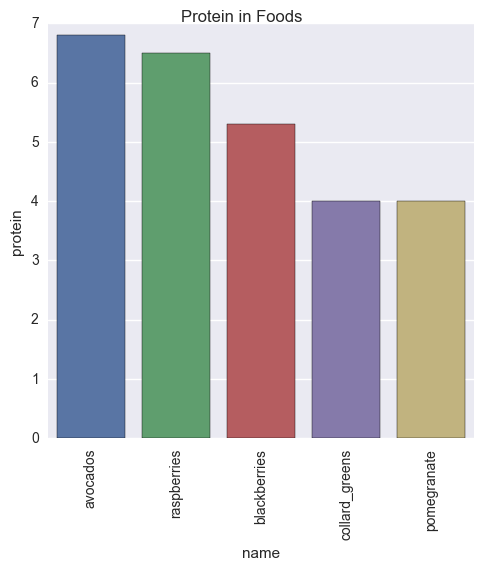

In [289]:
#Protein 
final_dfs = final_dfs.sort_values(by = "protein", axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last') 
pro=final_dfs[:5:] #Only first five rows
proplot=sns.factorplot("name", "protein", data = pro, kind = "bar", size=5) #Barplot
proplot.set_xticklabels(rotation=90) #Rotate axis labels for readability
proplot.fig.suptitle('Protein in Foods')
plt.show(proplot)
#avocados, raspberries, blackberries, collard greens, pomegranate

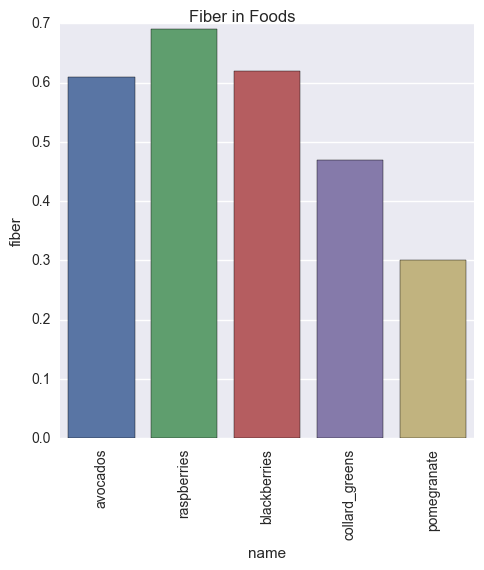

In [290]:
#Fiber
final_dfs = final_dfs.sort_values(by = "fiber", axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last') 
fib=final_dfs[:5:] #Only first five rows
fibplot=sns.factorplot("name", "fiber", data = pro, kind = "bar", size=5) #Barplot
fibplot.set_xticklabels(rotation=90) #Rotate axis labels for readability
fibplot.fig.suptitle('Fiber in Foods')
plt.show(fibplot)
#Avocados, raspberries, blackberries, pomegranate, collard greens

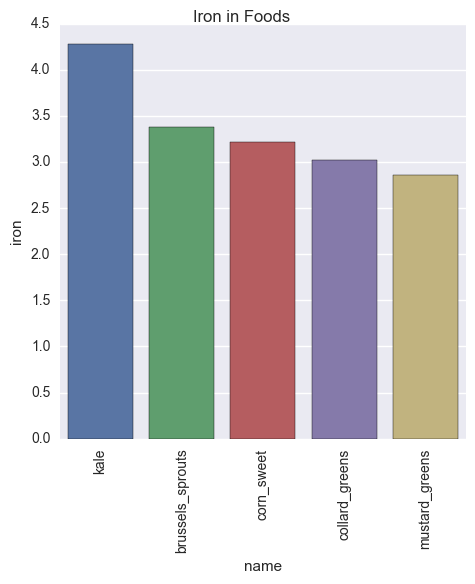

In [291]:
#Iron
final_dfs = final_dfs.sort_values(by = "iron", axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last') 
fe=final_dfs[:5:] #Only first five rows
feplot=sns.factorplot("name", "iron", data = fe, kind = "bar", size=5) #Barplot
feplot.set_xticklabels(rotation=90) #Rotate axis labels for readability
feplot.fig.suptitle('Iron in Foods')
plt.show(feplot)
#kale, brussel sprouts, sweet corn, collard greens, mustard greens

__1.4 Strategy Comments:__ The top 5 foods that are high in protein are also the top 5 foods high in fiber, which are avocados, raspberries, blackberries, collard greens, and pomegranates. Out of these, collard greens are also one of the highest in iron, and are on the lower end of the price/yield combination, which means they are maybe the best combination of price, yield, and nutrition. It should be noted that "nutrition" is a very subjective term, and we can make other plots that show correlations and associations of various nutrition information. In my opinion, collard greens stand out, and in general, the best combination of price, yield, and nutrition will tend to lie in the middle of our price/yield vs. foods graph (the very first one). To optimize all these things, you have to determine the tradeoffs you're willing to make, and potentially create some sort of weighted statistical model that can adjust "nutrition" with respect to other criteria.

Again, the issues from 1.2 still apply: we have no information for kiwis and the cabbage and cucumber information might not be exactly what we want it to be. In conclusion, nutrient information can be represented in more detail with more of a theoretical background or further instruction on what is the "best" nutrient, or also with more specifics on the benefits of subsetting this data into fruits, vegetables, fruit types, and vegetable types. 

__Assignment Information:__ Bounced ideas off of and received help from #teamdrenched (Hannah Kosinovsky, Chad Pickering, Ricky Safran), and some support from Patrick Vacek and Edie Espejo. As usual, this report would not be possible without Larry Page, Sergei Brin, and the good people from stackoverflow.  